# Moving Averages CINGULATE region

This makes the t-SNE and moving average of the second half

# 1) Imports

In [53]:
import os
import glob
import sys
import json

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)

In [54]:
import moving_averages as ma
import colorado as cld
import dico_toolbox as dtx
from tqdm import tqdm

import pandas as pd
import numpy as np
from scipy.spatial import distance

import plotly.graph_objects as go
import pickle
import matplotlib.pyplot as plt

from soma import aims

import torch

from sklearn.cluster import KMeans, SpectralClustering, AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.manifold import TSNE

import matplotlib.cm as cm

from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf, DictConfig

In [55]:
save_mesh = False
save_bucket = False

# 2) Functions and datasets

In [56]:
def closest_distance(centroid, df):
    """Returns closest point to centroid of a given cluster
    /!\ central_point is part of the defined set of points
    Args:
        IN: centroid: tuple of coordinates of centroid
            df: pandas.DataFrame with index corresponding to subjects and as many columns as coordinates
        OUT: central_point: subject ID corresponding to closest point to the centroid
    """
    # df must have as many columns as dimensions to consider
    distances = {}
    # Get distances to centroid for each point
    for sub in list(df.index):
        pos = [df.loc[sub][k] for k in range(0, len(df.columns))]
        distances[sub] = distance.euclidean(pos, centroid)
    # Get closest point to centroid
    central_point = min(distances, key=distances.get)
    return central_point

In [57]:
def mscatter(x, y, ax=None, m=None, **kw):
    if not ax:
        ax = plt.gca()
    sc = ax.scatter(x, y, **kw)
    if (m is not None) and (len(m) == len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

In [58]:
path = '/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/Rcrops/'

In [59]:
if torch.cuda.is_available():
    device = "cuda:0"
print(device)

cuda:0


In [60]:
run_dir = '/host/volatile/jc225751/Runs/29_MIDL_2022_clean'

In [61]:
# We load the mebeddings
result_dir = f"{run_dir}/Output/t-0.1/n-004_o-4_2nde_half"
train_val_embeddings_file = f"{result_dir}/train_val_embeddings.pt"
embeddings = torch.load(train_val_embeddings_file)
print(embeddings.shape)

torch.Size([550, 4])


In [62]:
# We load the labels
with open(f"{result_dir}/train_val_filenames.json", 'r') as f:
    subject_labels = json.load(f)
print(subject_labels[0])    

129634


# 3) T-SNE and different clusterings

In [63]:
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=50)
X_tsne = tsne.fit_transform(embeddings)

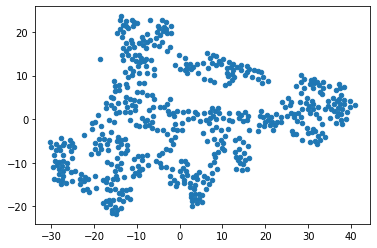

In [64]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], s=20, ax=ax)
plt.show()


In [65]:
X_tsne.shape 

(550, 2)

In [66]:
af = AffinityPropagation().fit(X_tsne)
cluster_labels_ini = af.labels_
initial_centers = af.cluster_centers_indices_
n_clusters_ = len(initial_centers)
while n_clusters_ > 5:
    af = AffinityPropagation().fit(X_tsne[af.cluster_centers_indices_])
    cluster_labels_af = af.labels_
    x_cluster_label_af = af.predict(X_tsne)
    n_clusters_ = len(af.cluster_centers_indices_)
    print(n_clusters_)

print(f"Average silhouette score: {metrics.silhouette_score(X_tsne, x_cluster_label_af)}")

3
Average silhouette score: 0.44469183683395386


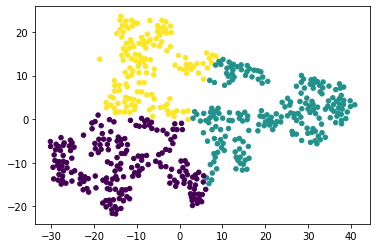

In [67]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], c=x_cluster_label_af, s=20, ax=ax)
plt.show()

In [68]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_tsne)
cluster_labels_kmeans = kmeans.labels_
x_cluster_label_kmeans = kmeans.predict(X_tsne)
clusters_centroids_kmeans = kmeans.cluster_centers_
print(f"clusters centroids = {clusters_centroids_kmeans.shape}")
print(f"Average silhouette score: {metrics.silhouette_score(X_tsne, cluster_labels_kmeans)}")


clusters centroids = (10, 2)
Average silhouette score: 0.4419712722301483


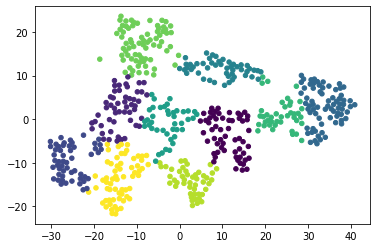

In [69]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], c=x_cluster_label_kmeans, s=20, ax=ax)
plt.show()

In [70]:
dbscan = DBSCAN(eps=2).fit(X_tsne)
cluster_labels_dbscan = dbscan.labels_
x_cluster_label_dbscan = dbscan.fit_predict(X_tsne)
print(f"Average silhouette score: {metrics.silhouette_score(X_tsne, cluster_labels_dbscan)}")


Average silhouette score: 0.20080047845840454


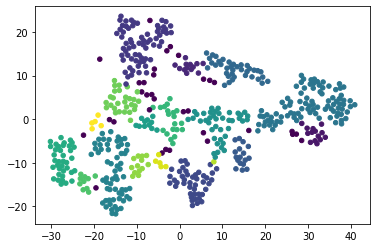

In [71]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], c=x_cluster_label_dbscan, s=20, ax=ax)
plt.show()

# 4) MA with AffinityPropagation clustering

In [72]:
x_cluster_label_af.shape

(550,)

In [73]:
dstrb_sub = pd.DataFrame(X_tsne, index=subject_labels, columns=[0,1])
dstrb_sub['af_label'] = x_cluster_label_af

In [74]:
dstrb_sub.head()

,0,1,af_label
129634,-0.922329,-15.407701,0
136833,1.267889,-9.561765,0
206222,31.663942,-2.766928,1
138837,1.526135,12.563971,2
987983,-5.150003,21.455168,2


In [75]:
clusters_centroids = af.cluster_centers_
print(f"cluster's centroids coordinates: \n {clusters_centroids}")

cluster's centroids coordinates: 
 [[-13.930139   -11.456533  ]
 [ 20.654316    -0.28824142]
 [-10.176218    13.37363   ]]


In [76]:
dstrb_sub.loc[dstrb_sub.index[0]]

0           -0.922329
1          -15.407701
af_label     0.000000
Name: 129634, dtype: float64

In [77]:
central = []
for i in range(clusters_centroids.shape[0]):
    central.append(closest_distance(clusters_centroids[i], dstrb_sub.drop(['af_label'], axis=1)))
    print(f"Closest subject to centroid of cluster {i} is {central[i]}")

Closest subject to centroid of cluster 0 is 378756
Closest subject to centroid of cluster 1 is 117021
Closest subject to centroid of cluster 2 is 604537


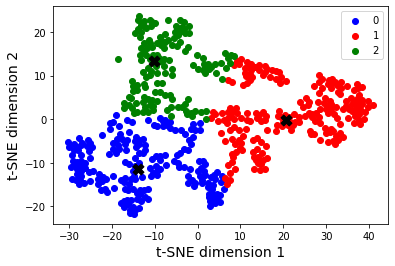

In [78]:
arr = np.array([np.array([dstrb_sub[k][i] for k in dstrb_sub.columns[0:2]]) for i in range(len(dstrb_sub))])

color_dict = {0: 'blue', 1:'red', 2:'green', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([dstrb_sub.af_label]):
    ix = np.where(dstrb_sub.af_label == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    ax.scatter(x, y, c = color_dict[g], label = g)

for g in np.unique([dstrb_sub.af_label]):
    ax.scatter(clusters_centroids[g][0],
               clusters_centroids[g][1],
               color='black',
               marker='X',
               s=120)

plt.xlabel(f't-SNE dimension 1', fontsize=14)
plt.ylabel(f't-SNE dimension 2', fontsize=14)
plt.legend()
plt.show()

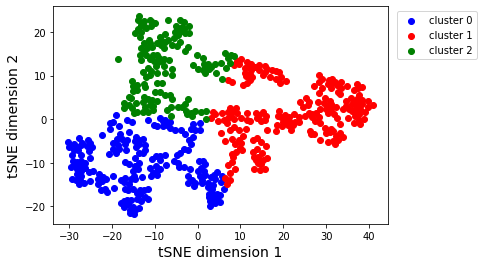

In [79]:
arr = np.array([np.array([dstrb_sub[k][i] for k in dstrb_sub.columns[0:2]]) for i in range(len(dstrb_sub))])

color_dict = {0: 'blue', 1:'red', 2:'green', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([dstrb_sub.af_label]):
    ix = np.where(dstrb_sub.af_label == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    ax.scatter(x, y, c = color_dict[g], label = f"cluster {g}")

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.legend(bbox_to_anchor=(1.28,1))
plt.show()

In [80]:
print(len(dstrb_sub))

550


In [81]:
clusters = []
for lab in np.unique([dstrb_sub.af_label]):
    cluster_df = dstrb_sub[dstrb_sub.af_label==lab]
    clusters.append(cluster_df)
for lab in np.unique([dstrb_sub.af_label]):
    assert(len(np.unique(list(clusters[lab].af_label)))==1)

### Creation of buckets dictionnary

In [82]:
bucket_path = '/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/Rbuckets/'
suffix_path = '_normalized.bck'
buckets = {}
for sub in tqdm(list(subject_labels)):
    bucket = aims.read(os.path.join(bucket_path, str(sub) + suffix_path))
    bucket = dtx.convert.bucket_aims_to_ndarray(bucket[0])
    buckets[sub] = bucket

100%|██████████| 550/550 [00:27<00:00, 20.04it/s]


In [83]:
clusters[0].index

Index(['129634', '136833', '562345', '182032', '206525', '131621', '887373',
       '412528', '529953', '770352',
       ...
       '199958', '189349', '933253', '103515', '723141', '352132', '123420',
       '349244', '792867', '188448'],
      dtype='object', length=198)

In [84]:
subjects = []
for lab in range(len(clusters)):
    subject = clusters[lab].index
    subjects.append(subject)

In [85]:
buckets_c = []
for lab in range(len(subjects)):
    bucket_c = {k: v for k,v in buckets.items() if k in list(subjects[lab])}
    buckets_c.append(bucket_c)

In [86]:
cld.draw(list(buckets_c[0].values())[0])

#### Alignement of the subjects to respective central subject

In [87]:
aligned_buckets = []
aligned_rot = []
aligned_transl = []

for lab in range(len(subjects)):
    print(lab)
    buck, rot, trans = ma.align_buckets_by_ICP_batch(buckets_c[lab], central[lab])
    aligned_buckets.append(buck)
    aligned_rot.append(rot)
    aligned_transl.append(trans)

>>> INFO moving_averages.transform - using 45 cores out of 48


0


Aligning buckets to 378756: 100%|██████████| 198/198 [00:01<00:00, 142.74it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48


1


Aligning buckets to 117021: 100%|██████████| 210/210 [00:01<00:00, 120.42it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48


2


Aligning buckets to 604537: 100%|██████████| 142/142 [00:01<00:00, 91.46it/s] 


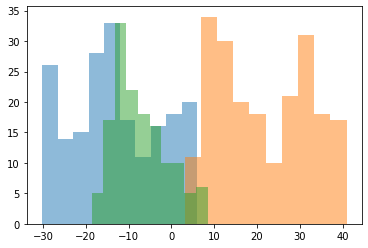

In [88]:
for lab in range(len(subjects)):
    plt.hist(clusters[lab][0], alpha=0.5)
plt.show()

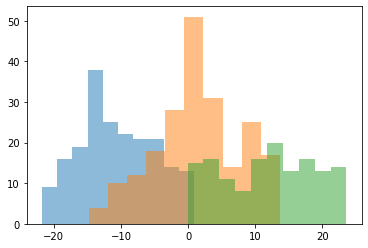

In [89]:
for lab in range(len(subjects)):
    plt.hist(clusters[lab][1], alpha=0.5)
plt.show()

In [90]:
def subj_count_extreme_coords(isodf, axis, min_coord, max_coord, num_coord=10):
    coord_values = np.linspace(min_coord, max_coord, num_coord)
    step = (coord_values[1] - coord_values[0])
    midpoint_min = coord_values[0] + step/2
    midpoint_max = coord_values[num_coord-1] - step/2
    coord_under = [elt for elt in isodf[axis] if elt<midpoint_min]
    coord_over = [elt for elt in isodf[axis] if elt>midpoint_max]
    num_subj_under = len(coord_under)
    num_subj_over = len(coord_over)
    return num_subj_under, num_subj_over

def get_MA_coords(isodf, axis, num_subj_threshold, num_coord=10):
    min_subj_coord = min(isodf[axis])
    max_subj_coord = max(isodf[axis])
    step = (max_subj_coord - min_subj_coord)/num_coord
    num_subj_under, num_subj_over = subj_count_extreme_coords(isodf, axis, min_subj_coord, max_subj_coord)
    while ((num_subj_under<num_subj_threshold)|(num_subj_over<num_subj_threshold)):
        step = (max_subj_coord - min_subj_coord)/num_coord
        if num_subj_under<num_subj_threshold:
            min_subj_coord = min_subj_coord + step
        if num_subj_over<num_subj_threshold:
            max_subj_coord = max_subj_coord - step
        num_subj_under, num_subj_over = subj_count_extreme_coords(isodf, axis, min_subj_coord, max_subj_coord)
    return np.linspace(min_subj_coord, max_subj_coord, num_coord)

In [91]:
clusters[0].head()

,0,1,af_label
129634,-0.922329,-15.407701,0
136833,1.267889,-9.561765,0
562345,-2.292734,-14.694978,0
182032,-30.172386,-5.149993,0
206525,4.107821,-19.321407,0


In [92]:
clusters_centroids

array([[-13.930139  , -11.456533  ],
       [ 20.654316  ,  -0.28824142],
       [-10.176218  ,  13.37363   ]], dtype=float32)

# Average on the first axis

In [93]:
FWHM = [10., 10., 10., 10.]
SPAM_vols = [[], []]
shift = [[], []]
for ax in [0, 1]:
    for i in range(len(subjects)):
        vol_1, shift_1 = ma.moving_averages_tools.calc_one_MA_volume(
            buckets_dict=aligned_buckets[i], 
            distance_df=clusters[i],
            axis_n=ax,
            center=clusters_centroids[i][ax],
            FWHM=FWHM[i])
        SPAM_vols_1 = dict({clusters_centroids[i][ax]:vol_1})
        SPAM_vols[ax].append(SPAM_vols_1)
        shift[ax].append(shift_1)


In [94]:
SPAM_meshes = [[], []]
thresholds = [[0.45, 0.44, 0.4, 0.4], [0.38, 0.42, 0.4, 0.42]]
threshold = 0.62

for ax in [0, 1]:
    for i in range(len(subjects)):
        SPAM_mesh_1 = {}

        for k, volume in tqdm(list(SPAM_vols[ax][i].items())[:]):
            SPAM_mesh_1[k]=dtx.convert.volume_to_mesh(
                            vol=volume,
                            gblur_sigma=0.0,
                            threshold=threshold,
                            deciReductionRate=0,
                            smoothRate=0.1)
        SPAM_meshes[ax].append(SPAM_mesh_1)


100%|██████████| 1/1 [00:00<00:00, 31.75it/s]


In [95]:
fig = cld.draw(list(SPAM_vols[1][0].values())[0], th_min=0.2)
cld.draw(list(SPAM_meshes[1][0].values())[0], fig=fig)

In [96]:
SPAM_meshes[0][1]

{20.654316: <soma.aims.AimsTimeSurface_3_VOID at 0x7f0343d7c0d8>}

In [97]:
if save_mesh:
    for ax in [0, 1]:
        for i in range(len(subjects)):
            for _, mesh in tqdm(SPAM_meshes[ax][i].items()):
                aims.write(mesh, f"AF_cluster_ax{ax}_{i}.mesh")

# Find typical examples

In [98]:
clusters[0].head()

,0,1,af_label
129634,-0.922329,-15.407701,0
136833,1.267889,-9.561765,0
562345,-2.292734,-14.694978,0
182032,-30.172386,-5.149993,0
206525,4.107821,-19.321407,0


In [99]:
clusters[0].nsmallest(2,[0])

,0,1,af_label
182032,-30.172386,-5.149993,0
107422,-30.128784,-6.293291,0


In [100]:
def compute_distance(df_in, centroid):
    """Computes distance from centroid"""
    df_out = df_in
    df_out['distance'] = (df_out[0]-centroid[0])**2 + (df_out[1]-centroid[1])**2
    return df_out

In [101]:
clusters[0] = compute_distance(clusters[0], clusters_centroids[0])

In [102]:
neighbours = []
for i in range(len(subjects)):
    clusters[i] = compute_distance(clusters[i], clusters_centroids[i])
    neighbours.append(list(clusters[i].nsmallest(4,'distance').index))
print(neighbours)

[['378756', '887373', '919966', '148941'], ['117021', '190132', '124826', '339847'], ['604537', '148335', '555651', '179245']]


In [103]:
if save_bucket:
    for idx, lab in enumerate(neighbours):
        for sub in lab:
            sub_bucket = dtx.convert.bucket_numpy_to_bucketMap_aims(buckets[sub])
            aims.write(sub_bucket, f"{idx}_{sub}.bck")